In [18]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import sys
sys.path.append("..")

from helper import load_countries, join_countries

In [19]:
DATA_PATH = "../../data/"

# External datasets

We first need to load the datasets we will use to compute the correlations.

The preprocessed countries contains the mapping between the different code standards used by each datasets

In [20]:
countries = pd.read_csv(DATA_PATH + "local_generated/preprocessed_countries.csv")
countries.Country = countries.Country.astype(str).str.strip()
countries.head(5)

,Country,Region,FIPS,ISO2,ISO3
0,Afghanistan,Asia,AF,AF,AFG
1,Albania,Europe,AL,AL,ALB
2,Algeria,Africa,AG,DZ,DZA
3,American Samoa,Oceania,AQ,AS,ASM
4,Andorra,Europe,AN,AD,AND


### Human development index ([source](http://hdr.undp.org/en/content/human-development-index-hdi))

The Human Development Index (HDI) is a statistic composite index of life expectancy, education, and per capita income indicators, which are used to rank countries into four tiers of human development.

In [21]:
hdi = pd.read_csv(DATA_PATH + "external_datasets/human_development_index_2017.csv")
hdi.head(5)

,HDI Rank,Country,ISO3,2015,2016,2017
0,168,Afghanistan,AFG,0.493,0.494,0.498
1,68,Albania,ALB,0.776,0.782,0.785
2,85,Algeria,DZA,0.749,0.753,0.754
3,35,Andorra,AND,0.854,0.856,0.858
4,147,Angola,AGO,0.572,0.577,0.581


In [22]:
hdi = hdi.set_index("ISO3")[["2017"]]
hdi.rename(columns={"2017":"hdi_2017"}, inplace=True)
hdi.head(5)

,hdi_2017
ISO3,
AFG,0.498
ALB,0.785
DZA,0.754
AND,0.858
AGO,0.581


### Environmental performance index ([source](https://epi.envirocenter.yale.edu/epi-downloads))

The Environmental Performance Index (EPI) is a method of quantifying and numerically marking the environmental performance of a state's policies. 

In [23]:
epi = pd.read_csv(DATA_PATH + "external_datasets/epi2018countrysnapshotv01.csv")
epi.head(5)

,code,iso,country,Pop,PopGrowthRate,PopDensity,GDP,LandArea,GDPpc,SDGI,EPI2018Score,EPI2018Rank
0,4,AFG,Afghanistan,34.656032,2.689163,53.083405,60.287050,652860.0,1739.583177,46.8,37.74,168
1,8,ALB,Albania,2.876101,-0.159880,104.967190,32.669916,27400.0,11359.099160,68.9,65.46,40
2,12,DZA,Algeria,40.606052,1.825463,17.048895,565.284000,2381741.0,13921.176080,68.8,57.18,88
3,24,AGO,Angola,28.813463,3.367572,23.111786,172.438000,1246700.0,5984.632947,50.2,37.44,170
4,28,ATG,Antigua and Barbuda,0.100963,1.035422,229.461364,2.121537,440.0,21013.017630,NaN,59.18,76


In [24]:
epi = epi[["iso", "country", "GDPpc", "EPI2018Score"]]
epi = epi.set_index("iso")
epi.head(5)

,country,GDPpc,EPI2018Score
iso,,,
AFG,Afghanistan,1739.583177,37.74
ALB,Albania,11359.099160,65.46
DZA,Algeria,13921.176080,57.18
AGO,Angola,5984.632947,37.44
ATG,Antigua and Barbuda,21013.017630,59.18


In [25]:
external_data = hdi.join(epi).join(countries.set_index("ISO3")[["ISO2", "Region"]])
external_data.head(5)

,hdi_2017,country,GDPpc,EPI2018Score,ISO2,Region
ISO3,,,,,,
AFG,0.498,Afghanistan,1739.583177,37.74,AF,Asia
AGO,0.581,Angola,5984.632947,37.44,AO,Africa
ALB,0.785,Albania,11359.099160,65.46,AL,Europe
AND,0.858,NaN,NaN,NaN,AD,Europe
ARE,0.863,United Arab Emirates,67133.014840,58.90,AE,Asia


# Mentions ratios

Here we load the mentions ratios with the outliers removed (for details, see [mentions_counts_by_domain_locations.ipynb](../mentions_count/mentions_counts_by_domain_locations.ipynb)) and then we compute the mean ratio for each countries.

In [29]:
MENTIONS_COUNTS_FILE = DATA_PATH + "from_cluster/mentions_counts_by_domain_state_and_days_filtered_5themes.csv.NO_OUTLIERS.csv"

In [30]:
mentions_ratios = pd.read_csv(MENTIONS_COUNTS_FILE, index_col=0)
mentions_ratios.sample(10)

,ISO,DOMAIN_COUNTRY,GLOBAL_COUNT,ENV_COUNT,Country,Region,DATE,Ratio
42441,LC,Saint Lucia,133,3.0,Saint Lucia,Americas,2015-09-17,0.022556
5006,AZ,Azerbaijan,2012,26.0,Azerbaijan,Asia,2016-04-05,0.012922
77603,ZM,Zambia,295,7.0,Zambia,Africa,2016-08-29,0.023729
21432,FJ,Fiji,483,2.0,Fiji,Oceania,2015-02-26,0.004141
25764,GR,Greece,777,7.0,Greece,Europe,2016-06-10,0.009009
57648,PK,Pakistan,10174,390.0,Pakistan,Asia,2015-03-26,0.038333
52446,NO,Norway,204,13.0,Norway,Europe,2015-12-23,0.063725
10943,BY,Belarus,357,6.0,Belarus,Europe,2016-09-05,0.016807
61985,SA,Saudi Arabia,1155,28.0,Saudi Arabia,Asia,2016-05-23,0.024242
28924,IE,Ireland,4740,265.0,Ireland,Europe,2015-04-28,0.055907


In [31]:
means = mentions_ratios.groupby("ISO").mean()
means = means.assign(MEAN=means.ENV_COUNT/means.GLOBAL_COUNT)[["MEAN"]]
ratios = means
#medians = mentions_ratios.groupby("ISO").median()
#medians = medians.assign(MEDIAN=medians.ENV_COUNT/medians.GLOBAL_COUNT)[["MEDIAN"]]
#ratios = means.join(medians)

In [32]:
ratios.sample(10)

,MEAN
ISO,
TN,0.106031
HU,0.045178
VI,0.117427
ET,0.046730
ZW,0.019106
VG,0.175258
AE,0.044959
PT,0.067934
IT,0.022117


# Join to external datasets

In [33]:
joined = ratios.join(external_data.set_index("ISO2", drop=True), how="left")
joined = joined[joined.Region != "Oceania"]
joined.head(5)

,MEAN,hdi_2017,country,GDPpc,EPI2018Score,Region
AE,0.044959,0.863,United Arab Emirates,67133.014840,58.90,Asia
AF,0.024477,0.498,Afghanistan,1739.583177,37.74,Asia
AI,0.121071,NaN,NaN,NaN,NaN,NaN
AL,0.057525,0.785,Albania,11359.099160,65.46,Europe
AM,0.012836,0.755,Armenia,8190.239289,62.07,Asia


In [34]:
joined.describe()

,MEAN,hdi_2017,GDPpc,EPI2018Score
count,166.000000,148.000000,144.000000,144.000000
mean,0.061894,0.734230,20548.247667,58.374792
std,0.055551,0.150208,20190.558663,13.182995
min,0.007897,0.354000,753.557379,29.560000
25%,0.030394,0.611000,5900.074333,47.910000
50%,0.042601,0.757000,14079.303900,58.740000
75%,0.073850,0.853500,28377.230410,66.210000
max,0.386071,0.953000,118207.069500,87.420000


In [35]:
def lmplot(data, x, y="MEAN", title="", world=False, figsize=(12,6)):
    plt.figure(figsize=figsize)
    plt.suptitle(title)
    sns.lmplot(x, y, data=data, col="Region" if not world else None, robust=True)

/Users/damien/miniconda3/envs/ada/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 864x432 with 0 Axes>

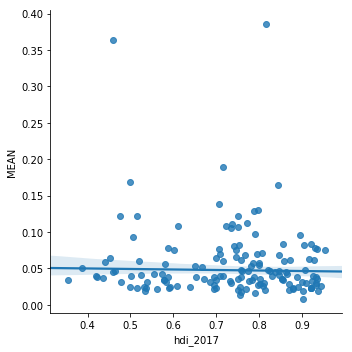

<Figure size 864x432 with 0 Axes>

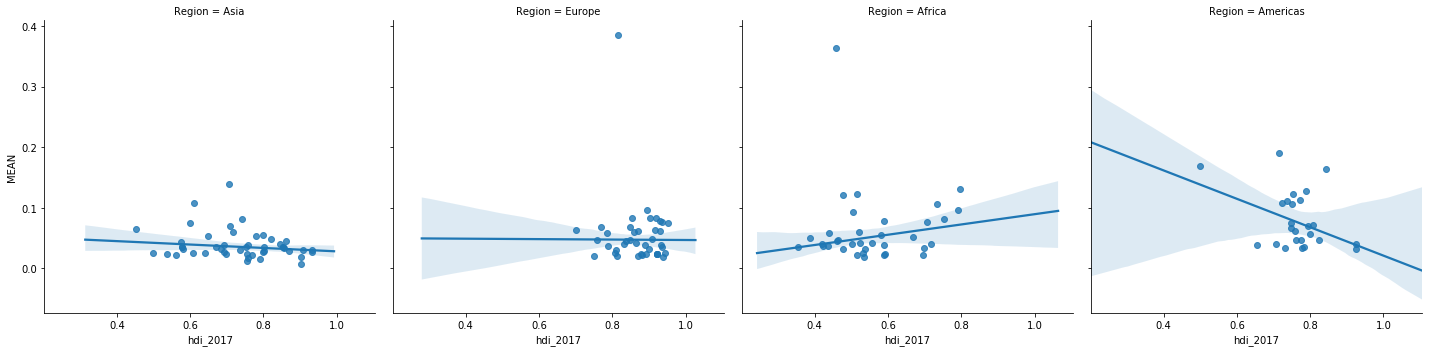

In [36]:
lmplot(joined, "hdi_2017", "MEAN", "Human development index vs ratio mean", world=True)
lmplot(joined, "hdi_2017", "MEAN", "Human development index vs ratio mean", world=False)

<Figure size 864x432 with 0 Axes>

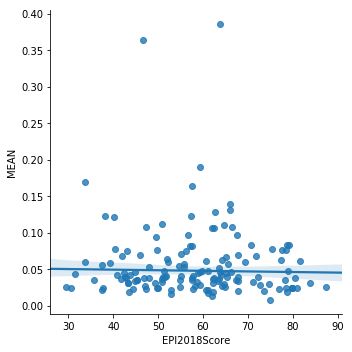

<Figure size 864x432 with 0 Axes>

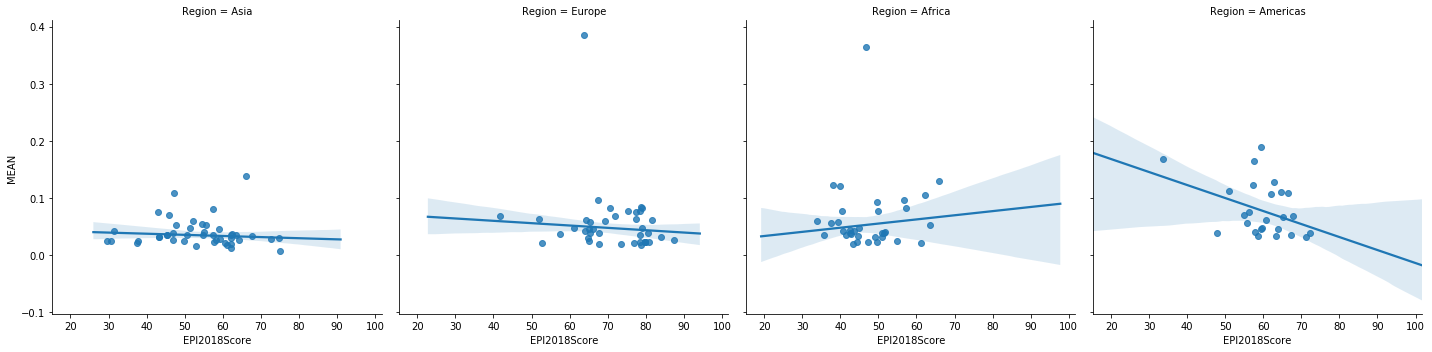

In [37]:
lmplot(joined, "EPI2018Score", "MEAN", "Environmental performance index vs ratio mean", world=True)
lmplot(joined, "EPI2018Score", "MEAN", "Environmental performance index vs ratio mean", world=False)

<Figure size 864x432 with 0 Axes>

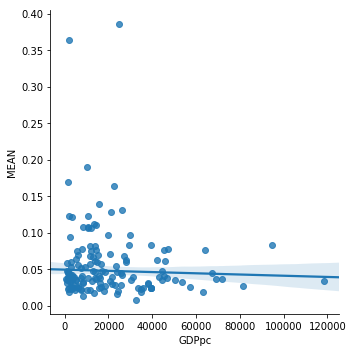

<Figure size 864x432 with 0 Axes>

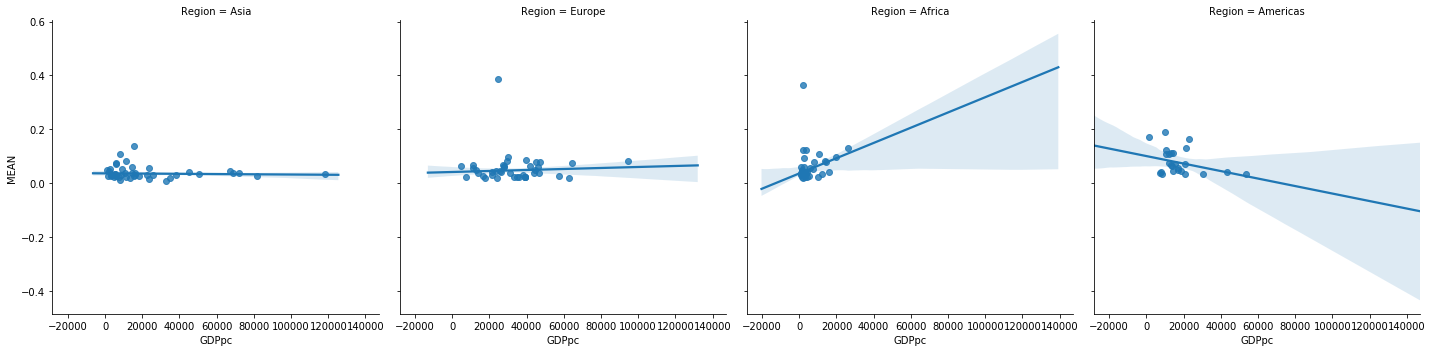

In [38]:
lmplot(joined, "GDPpc", "MEAN", "GDP per capita vs ratio mean", world=True)
lmplot(joined, "GDPpc", "MEAN", "GDP per capita vs ratio mean", world=False)